# Naive Bayes SMS Spam Classification

## Overview
This document outlines a Naive Bayes classifier from scratch to classify SMS messages as spam or legitimate (ham).

## Dataset Selection
We've selected the **SMS Spam Collection Dataset** from Kaggle for this assignment. This dataset contains SMS messages labeled as spam or ham and is well-suited for demonstrating the Naive Bayes algorithm for the following reasons:
- It represents a real-world text classification problem
- It's a binary classification task with clear evaluation metrics
- Text classification is a domain where Naive Bayes excels
- The dataset is clean and requires minimal preprocessing

## Implementation Phases
- Phase 1: Environment Setup and Data Exploration 
- Phase 2: Text Preprocessing
- Phase 3: Naive Bayes Implementation
- Phase 4: Data Preparation
- Phase 5: Training and Evaluation
- Phase 6: Model Refinement and Analysis
- Phase 7: Bayes Theorem Explanation and Visualization
- Phase 8: Documentation and Reporting

## Theoretical Foundation

The SMS Spam Classsifier is based on the Multinomial Naive Bayes variant, which is appropriate for text classification with the following theoretical components:

1. **Prior Probabilities**:
   - P(Spam): Proportion of spam messages in the training data
   - P(Ham): Proportion of ham messages in the training data

2. **Likelihood Calculation**:
   - P(word|Spam): Probability of word occurrence in spam messages
   - P(word|Ham): Probability of word occurrence in ham messages

3. **Posterior Calculation**:
   - P(Spam|Message) ∝ P(Spam) × ∏ P(word_i|Spam)
   - P(Ham|Message) ∝ P(Ham) × ∏ P(word_i|Ham)

4. **Naive Assumption**:
   - Word occurrences are conditionally independent given the class
   - P(word_1, word_2, ..., word_n|Class) = P(word_1|Class) × P(word_2|Class) × ... × P(word_n|Class)

## Expected Results

We expect our implementation to achieve:
- Accuracy of approximately 97-98%
- High precision to minimize false positives
- Strong recall to catch most spam messages
- Clear visualization of model performance
- Insightful word importance analysis

## Conclusion

### Phase 1: Environment Setup and Data Exploration
- Import necessary libraries (NumPy, Pandas, Matplotlib, etc.)
- Load and examine the SMS dataset structure
- Analyze class distribution and message characteristics
- Check for data quality issues (missing values, duplicates)
- Visualize message length distributions by class

In [1]:
# Importing necessary libraries (NumPy, Pandas, Matplotlib)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

#### 2. Load and Explore the Dataset

In [2]:
# Load the SMS Spam Collection dataset
df = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin-1')

In [3]:
# Initial inspection
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (5572, 5)

First 5 rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [4]:
# Check for column information
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [5]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [6]:
# The dataset typically has some unnecessary columns (Unnamed: 2, Unnamed: 3, Unnamed: 4)
# Let's drop them and rename the remaining columns for clarity
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, errors='ignore')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})

print("\nCleaned dataset:")
print(df.head())


Cleaned dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [7]:
# Check class distribution
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True) * 100)


Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


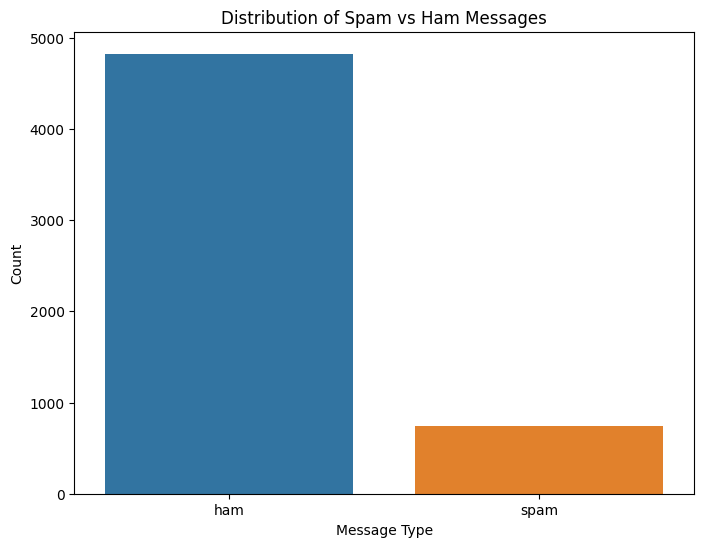

In [8]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [9]:
# Analyze message lengths
df['length'] = df['message'].apply(len)
print("\nMessage length statistics:")
print(df.groupby('label')['length'].describe())


Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

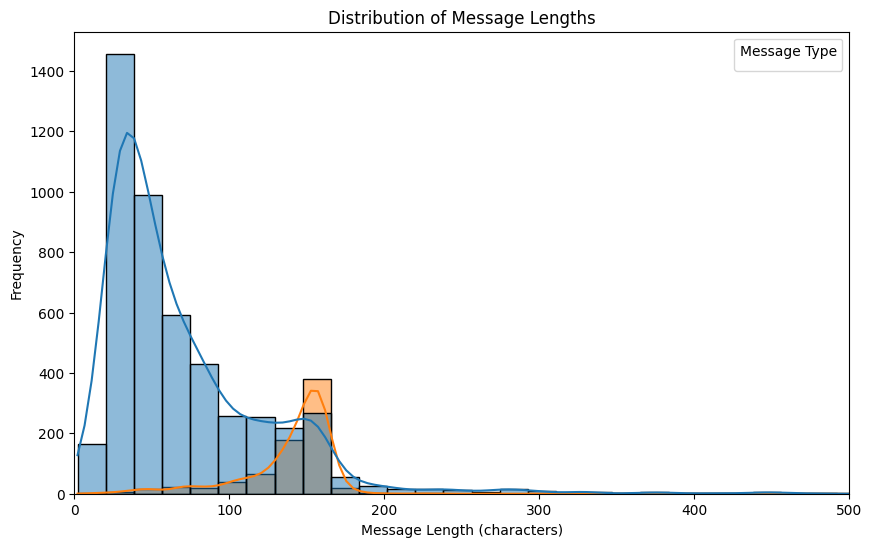

In [10]:
# Visualize message lengths by class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Limit x-axis for better visualization
plt.legend(title='Message Type')
plt.show()

In [11]:
# Look at some examples of spam and ham messages
print("\nExample of Ham messages:")
print(df[df['label'] == 'ham'].head(3)['message'].values)

print("\nExample of Spam messages:")
print(df[df['label'] == 'spam'].head(3)['message'].values)


Example of Ham messages:
['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'
 'Ok lar... Joking wif u oni...'
 'U dun say so early hor... U c already then say...']

Example of Spam messages:
["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv"
 'WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.']


In [12]:
# Convert labels to binary format (1 for spam, 0 for ham)
df['label_num'] = df['label'].map({'spam': 1, 'ham': 0})

### Phase 2: Text Preprocessing
- Implement text cleaning functions:
  - Convert to lowercase
  - Remove punctuation and special characters
  - Remove numbers (optional)
  - Split into tokens (words)
- Implement stop words removal
- Create vocabulary (set of unique words across all messages)
- Implement bag-of-words vectorization
- Analyze word frequency distributions in spam vs. ham messages

In [13]:
# 3. Implementing Preprocessing Functions

def tokenize_text(message):
    """
    Convert a message to lowercase, remove punctuation, and split into words.
    
    Args:
        message (str): The text message to tokenize
        
    Returns:
        list: A list of tokens (words)
    """
    # Convert to lowercase
    message = message.lower()
    
    # Remove punctuation
    message = re.sub(f'[{string.punctuation}]', ' ', message)
    
    # Remove numbers (optional, comment if you want to keep numbers)
    message = re.sub(r'\d+', '', message)
    
    # Split into words and remove extra whitespaces
    tokens = message.split()
    
    return tokens

# Define a list of English stop words
STOP_WORDS = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
    'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 
    'will', 'just', 'don', 'should', 'now'
]

def remove_stopwords(tokens):
    """
    Remove common stopwords from the token list.
    
    Args:
        tokens (list): List of tokens (words)
        
    Returns:
        list: Filtered list with stopwords removed
    """
    return [word for word in tokens if word not in STOP_WORDS]

In [14]:
# Test the preprocessing functions on a sample message
sample_message = "Hello! This is a sample message with some numbers 123. Is it working?"
tokens = tokenize_text(sample_message)
filtered_tokens = remove_stopwords(tokens)

print("\nPreprocessing example:")
print("Original message:", sample_message)
print("After tokenization:", tokens)
print("After stopword removal:", filtered_tokens)


Preprocessing example:
Original message: Hello! This is a sample message with some numbers 123. Is it working?
After tokenization: ['hello', 'this', 'is', 'a', 'sample', 'message', 'with', 'some', 'numbers', 'is', 'it', 'working']
After stopword removal: ['hello', 'sample', 'message', 'numbers', 'working']


In [15]:
# Process all messages and display some examples of processed text
df['tokens'] = df['message'].apply(tokenize_text)
df['filtered_tokens'] = df['tokens'].apply(remove_stopwords)

print("\nExample of preprocessed messages:")
for i in range(3):
    print(f"Original: {df['message'].iloc[i]}")
    print(f"Processed: {df['filtered_tokens'].iloc[i]}")
    print()


Example of preprocessed messages:
Original: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Processed: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']

Original: Ok lar... Joking wif u oni...
Processed: ['ok', 'lar', 'joking', 'wif', 'u', 'oni']

Original: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Processed: ['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']



In [16]:
# Create vocabulary (all unique words across all messages)
def create_vocabulary(all_filtered_tokens):
    """
    Create a vocabulary (set of unique words) from all tokenized messages.
    
    Args:
        all_filtered_tokens (list): List of lists containing tokens from all messages
        
    Returns:
        set: Set of unique words (vocabulary)
    """
    vocabulary = set()
    for tokens in all_filtered_tokens:
        vocabulary.update(tokens)
    return vocabulary

# Create the vocabulary
vocabulary = create_vocabulary(df['filtered_tokens'])
print(f"Vocabulary size: {len(vocabulary)} unique words")

# Look at some vocabulary words
print("\nSample of vocabulary words:")
print(list(vocabulary)[:20])

# Now let's examine word frequency distribution
all_words = []
for tokens in df['filtered_tokens']:
    all_words.extend(tokens)

word_freq = Counter(all_words)
print("\nMost common words in the dataset:")
print(word_freq.most_common(20))

Vocabulary size: 7828 unique words

Sample of vocabulary words:
['grumpy', 'potato', 'onto', 'sometimes', 'ke', 'brolly', 'meaningful', 'resolution', 'rolled', 'ed', 'mind', 'costs', 'discuss', 'none', 'wasted', 'fired', 'cock', 'lyfu', 'bit', 'slippery']

Most common words in the dataset:
[('u', 1205), ('call', 593), ('m', 436), ('get', 394), ('ur', 381), ('gt', 318), ('lt', 316), ('å£', 298), ('ok', 292), ('free', 286), ('go', 284), ('ll', 263), ('know', 261), ('like', 245), ('good', 245), ('got', 238), ('day', 233), ('come', 229), ('time', 220), ('love', 209)]


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


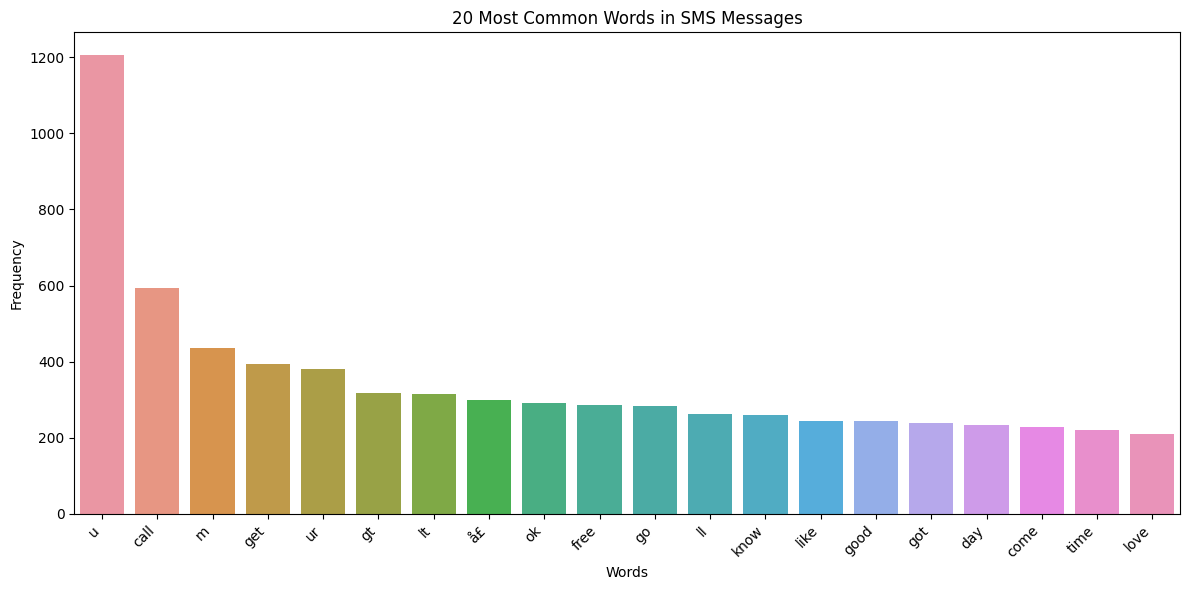

In [17]:
# Visualize most common words
plt.figure(figsize=(12, 6))
common_words = dict(word_freq.most_common(20))
sns.barplot(x=list(common_words.keys()), y=list(common_words.values()))
plt.title('20 Most Common Words in SMS Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Let's also look at most common words in spam vs ham
spam_words = []
ham_words = []

for i, row in df.iterrows():
    if row['label'] == 'spam':
        spam_words.extend(row['filtered_tokens'])
    else:
        ham_words.extend(row['filtered_tokens'])

spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

print("\nMost common words in SPAM messages:")
print(spam_word_freq.most_common(20))

print("\nMost common words in HAM messages:")
print(ham_word_freq.most_common(20))


Most common words in SPAM messages:
[('call', 357), ('å£', 294), ('free', 226), ('u', 181), ('txt', 170), ('p', 159), ('ur', 144), ('mobile', 128), ('text', 126), ('stop', 122), ('claim', 113), ('reply', 104), ('www', 98), ('prize', 93), ('get', 86), ('cash', 76), ('won', 76), ('uk', 73), ('nokia', 71), ('send', 70)]

Most common words in HAM messages:
[('u', 1024), ('m', 401), ('gt', 318), ('lt', 316), ('get', 308), ('ok', 287), ('ll', 259), ('go', 252), ('ur', 237), ('know', 236), ('call', 236), ('good', 233), ('like', 232), ('got', 231), ('come', 227), ('day', 209), ('time', 201), ('love', 199), ('going', 169), ('one', 167)]


In [19]:
# Create vectorization function (Bag of Words)
def create_bow_vector(tokens, vocabulary):
    """
    Create a bag-of-words vector for a message.
    
    Args:
        tokens (list): List of tokens (words) in the message
        vocabulary (set): Set of all unique words in the dataset
        
    Returns:
        dict: Dictionary with word counts for the message
    """
    # Initialize vector with zeros
    bow_vector = {word: 0 for word in vocabulary}
    
    # Count word occurrences
    word_counts = Counter(tokens)
    
    # Update the vector with word counts
    for word, count in word_counts.items():
        if word in vocabulary:  # Check if word is in vocabulary
            bow_vector[word] = count
    
    return bow_vector

# Test the vectorization function
sample_tokens = df['filtered_tokens'].iloc[0]
sample_bow = create_bow_vector(sample_tokens, vocabulary)

print("\nBag of Words vectorization example:")
print("Original tokens:", sample_tokens)
print("Resulting vector (showing non-zero entries):")
non_zero = {word: count for word, count in sample_bow.items() if count > 0}
print(non_zero)


Bag of Words vectorization example:
Original tokens: ['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
Resulting vector (showing non-zero entries):
{'great': 1, 'e': 1, 'jurong': 1, 'la': 1, 'amore': 1, 'world': 1, 'cine': 1, 'bugis': 1, 'wat': 1, 'available': 1, 'point': 1, 'buffet': 1, 'got': 1, 'crazy': 1, 'n': 1, 'go': 1}


### Phase 3: Naive Bayes Implementation
- Implement MultinomialNaiveBayes class with the following methods:
  - `__init__`: Initialize with smoothing parameter
  - `fit`: Train the model on training data
  - `calculate_priors`: Calculate prior probabilities P(Spam) and P(Ham)
  - `calculate_word_probabilities`: Calculate conditional probabilities P(word|class)
  - `predict_proba`: Calculate posterior probabilities using log probabilities
  - `predict`: Generate class predictions
- Implement Laplace smoothing to handle unseen words
- Use logarithmic probabilities to avoid numerical underflow

In [20]:
## 3. Naive Bayes Implementation from Scratch

class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        """
        Initialize the Multinomial Naive Bayes classifier.
        
        Args:
            alpha (float): Smoothing parameter for Laplace smoothing.
                           Default is 1.0 (Laplace smoothing).
        """
        self.alpha = alpha  # Smoothing parameter
        self.class_priors = {}  # Prior probabilities P(class)
        self.word_probs = {}  # Conditional probabilities P(word|class)
        self.classes = None  # List of unique classes
        self.vocabulary = None  # Set of all unique words
    
    def fit(self, X_train, y_train):
        """
        Train the Naive Bayes classifier.
        
        Args:
            X_train (list): List of dictionaries, each containing word frequencies for a message
            y_train (list): List of labels (0 for ham, 1 for spam)
        """
        n_samples = len(y_train)
        self.classes = np.unique(y_train)
        
        # Calculate prior probabilities P(class)
        self.calculate_priors(y_train)
        
        # Store the vocabulary (unique words across all messages)
        self.vocabulary = set()
        for bow_vector in X_train:
            self.vocabulary.update(bow_vector.keys())
        
        # Calculate word probabilities for each class
        self.calculate_word_probabilities(X_train, y_train)
        
        return self
    
    def calculate_priors(self, y_train):
        """
        Calculate prior probabilities for each class.
        
        Args:
            y_train (list): List of labels
        """
        n_samples = len(y_train)
        # Count occurrences of each class
        class_counts = Counter(y_train)
        
        # Calculate prior probabilities
        for cls in self.classes:
            self.class_priors[cls] = class_counts[cls] / n_samples
    
    def calculate_word_probabilities(self, X_train, y_train):
        """
        Calculate conditional probabilities P(word|class) for all words in vocabulary.
        
        Args:
            X_train (list): List of dictionaries containing word frequencies
            y_train (list): List of labels
        """
        # Initialize word counts for each class
        word_counts = {cls: defaultdict(int) for cls in self.classes}
        # Initialize total word counts for each class
        total_counts = {cls: 0 for cls in self.classes}
        
        # Count word occurrences for each class
        for i, bow_vector in enumerate(X_train):
            cls = y_train[i]
            for word, count in bow_vector.items():
                word_counts[cls][word] += count
                total_counts[cls] += count
        
        # Calculate conditional probabilities with Laplace smoothing
        self.word_probs = {cls: {} for cls in self.classes}
        
        # Vocabulary size for Laplace smoothing
        vocab_size = len(self.vocabulary)
        
        for cls in self.classes:
            # Calculate denominator for smoothing: total words in class + alpha * vocabulary size
            denominator = total_counts[cls] + self.alpha * vocab_size
            
            # Calculate probabilities for each word in vocabulary
            for word in self.vocabulary:
                # Apply Laplace smoothing: (word_count + alpha) / (total_count + alpha * vocab_size)
                numerator = word_counts[cls].get(word, 0) + self.alpha
                self.word_probs[cls][word] = numerator / denominator
    
    def predict_proba(self, X_test):
        """
        Calculate posterior probabilities for each class.
        
        Args:
            X_test (list): List of dictionaries containing word frequencies for test messages
        
        Returns:
            list: List of predicted probabilities for each class
        """
        # Check if model has been trained
        if not self.word_probs:
            raise ValueError("Model not fitted. Call 'fit' first.")
        
        # List to store probabilities for each message
        all_probs = []
        
        for bow_vector in X_test:
            # Calculate log probabilities for each class
            log_probs = {cls: np.log(prior) for cls, prior in self.class_priors.items()}
            
            # Add log of word probabilities for each word in the message
            for word, count in bow_vector.items():
                if word in self.vocabulary:  # Only consider words in training vocabulary
                    for cls in self.classes:
                        # Multiply probability by word count (equivalent to adding log probabilities)
                        log_probs[cls] += count * np.log(self.word_probs[cls][word])
            
            # Convert log probabilities to actual probabilities
            # First, find the maximum log probability to avoid numerical underflow
            max_log_prob = max(log_probs.values())
            
            # Normalize and exponentiate
            probs = {}
            total_prob = 0
            for cls, log_prob in log_probs.items():
                probs[cls] = np.exp(log_prob - max_log_prob)
                total_prob += probs[cls]
            
            # Normalize to get proper probabilities
            for cls in probs:
                probs[cls] /= total_prob if total_prob > 0 else 1
            
            all_probs.append(probs)
        
        return all_probs
    
    def predict(self, X_test):
        """
        Predict class labels for test data.
        
        Args:
            X_test (list): List of dictionaries containing word frequencies
        
        Returns:
            list: Predicted labels for each message
        """
        # Get probabilities for each class
        all_probs = self.predict_proba(X_test)
        
        # Choose the class with highest probability for each message
        predictions = []
        for probs in all_probs:
            predictions.append(max(probs, key=probs.get))
        
        return predictions

### Phase 4: Data Preparation
- Split dataset into training (80%) and testing (20%) sets
- Ensure balanced class representation in both sets
- Convert messages to bag-of-words vectors
- Prepare data structures for training

In [21]:
## 4. Prepare Training and Testing Data

# Convert the messages to bag-of-words vectors
def prepare_data(df, vocabulary=None):
    """
    Prepare the data for training/testing by converting messages to bag-of-words vectors.
    
    Args:
        df (DataFrame): DataFrame containing the messages and their tokens
        vocabulary (set, optional): If provided, use this vocabulary instead of creating a new one
    
    Returns:
        tuple: X (bag-of-words vectors), y (labels), and vocabulary
    """
    # Create vocabulary if not provided
    if vocabulary is None:
        vocabulary = create_vocabulary(df['filtered_tokens'])
    
    # Convert messages to bag-of-words vectors
    X = []
    for tokens in df['filtered_tokens']:
        X.append(create_bow_vector(tokens, vocabulary))
    
    # Get labels
    y = df['label_num'].values
    
    return X, y, vocabulary

# Split the data into training and testing sets
def split_data(df, test_size=0.2, random_state=42):
    """
    Split the data into training and testing sets.
    
    Args:
        df (DataFrame): DataFrame containing the messages and labels
        test_size (float): Proportion of the dataset to include in the test split
        random_state (int): Random seed for reproducibility
    
    Returns:
        tuple: train_df, test_df (DataFrames for training and testing)
    """
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
        stratify=df['label']  # Ensure proportional representation of classes
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    return train_df, test_df

# Split the dataset
train_df, test_df = split_data(df)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 4457
Testing set size: 1115


In [22]:
# Check class distribution in splits
print("\nClass distribution in training set:")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\nClass distribution in testing set:")
print(test_df['label'].value_counts(normalize=True) * 100)


Class distribution in training set:
label
ham     86.582903
spam    13.417097
Name: proportion, dtype: float64

Class distribution in testing set:
label
ham     86.636771
spam    13.363229
Name: proportion, dtype: float64


In [23]:
# Prepare training and testing data
X_train, y_train, vocabulary = prepare_data(train_df)
X_test, y_test, _ = prepare_data(test_df, vocabulary)

In [24]:
# Validate data shapes
print(f"\nNumber of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print(f"Vocabulary size: {len(vocabulary)}")


Number of training samples: 4457
Number of testing samples: 1115
Vocabulary size: 6952


### Phase 5: Training and Evaluation
- Train the model on the training data
- Generate predictions on test data
- Implement comprehensive evaluation metrics:
  - Confusion matrix
  - Accuracy, precision, recall, F1-score
  - ROC curve and AUC
- Visualize results with confusion matrix heatmap and ROC curve
- Identify most indicative words for spam and ham
- Perform error analysis on misclassified messages

In [25]:
# 5. Train and Evaluate the Model

# Train the Naive Bayes model
nb_classifier = MultinomialNaiveBayes(alpha=1.0)  # Using Laplace smoothing with alpha=1.0
nb_classifier.fit(X_train, y_train)

# Calculate prior probabilities
print("\nPrior probabilities:")
for cls, prior in nb_classifier.class_priors.items():
    class_name = "Spam" if cls == 1 else "Ham"
    print(f"{class_name}: {prior:.4f}")

# Make predictions on test data
y_pred = nb_classifier.predict(X_test)

# Get probability estimates
y_pred_proba = nb_classifier.predict_proba(X_test)
spam_probs = [probs[1] for probs in y_pred_proba]  # Extract spam probabilities


Prior probabilities:
Ham: 0.8658
Spam: 0.1342


In [26]:
# 6. Evaluation metrics
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """
    Evaluate the model using various metrics.
    
    Args:
        y_true (array): True labels
        y_pred (array): Predicted labels
        y_pred_proba (array, optional): Predicted probabilities for the positive class
    
    Returns:
        dict: Dictionary containing evaluation metrics
    """
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Calculate ROC curve and AUC if probabilities are provided
    roc_auc = None
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
    
    # Store results in dictionary
    results = {
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'fpr': fpr if roc_auc is not None else None,
        'tpr': tpr if roc_auc is not None else None
    }
    
    return results

# Evaluate the model
evaluation = evaluate_model(y_test, y_pred, spam_probs)


In [27]:
# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Accuracy: {evaluation['accuracy']:.4f}")
print(f"Precision: {evaluation['precision']:.4f}")
print(f"Recall: {evaluation['recall']:.4f}")
print(f"F1-score: {evaluation['f1_score']:.4f}")
print(f"ROC AUC: {evaluation['roc_auc']:.4f}")



Evaluation Metrics:
Accuracy: 0.9874
Precision: 0.9720
Recall: 0.9329
F1-score: 0.9521
ROC AUC: 0.9842


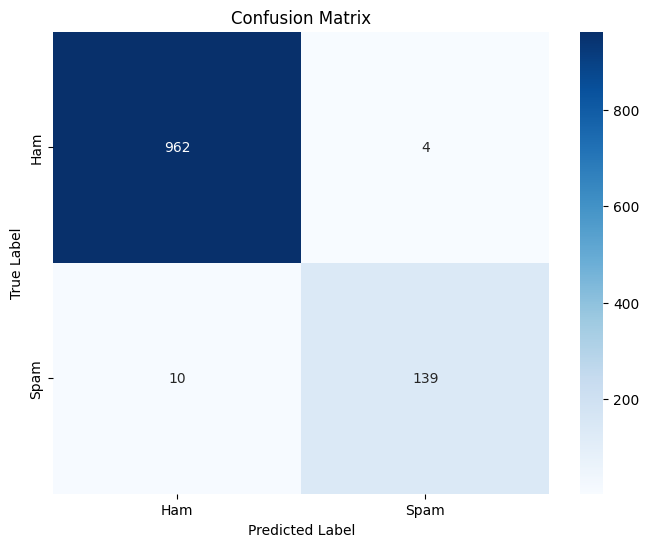

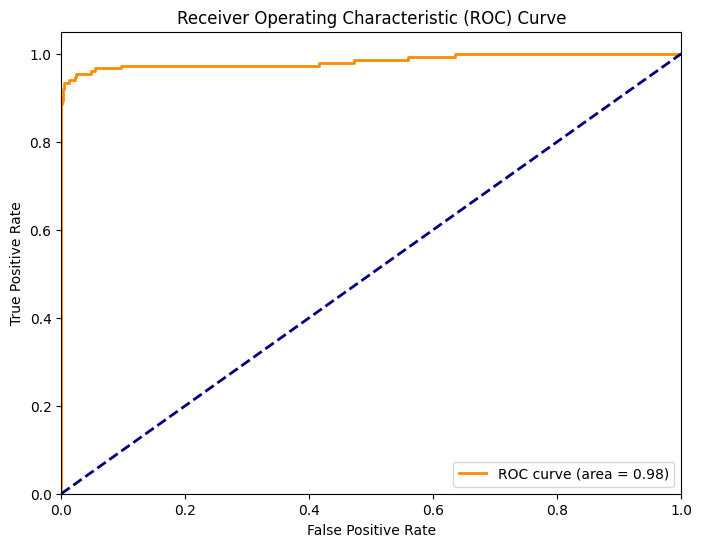

In [28]:
# 7. Visualize Results

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = evaluation['confusion_matrix']
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr = evaluation['fpr'], evaluation['tpr']
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {evaluation["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Find most indicative words for each class
def get_most_indicative_words(word_probs, num_words=20):
    """
    Find the most indicative words for each class.
    
    Args:
        word_probs (dict): Dictionary of word probabilities by class
        num_words (int): Number of top words to return
    
    Returns:
        dict: Dictionary with top indicative words for each class
    """
    # Calculate word importance (ratio of probabilities)
    word_importance = {}
    for word in word_probs[1].keys():  # Assuming class 1 is spam
        # Calculate ratio: P(word|spam) / P(word|ham)
        ratio = word_probs[1][word] / word_probs[0][word]
        word_importance[word] = ratio
    
    # Get top spam words (highest ratio)
    top_spam_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)[:num_words]
    
    # Get top ham words (lowest ratio)
    top_ham_words = sorted(word_importance.items(), key=lambda x: x[1])[:num_words]
    
    return {
        'spam': top_spam_words,
        'ham': top_ham_words
    }

# Get most indicative words
indicative_words = get_most_indicative_words(nb_classifier.word_probs)

print("\nTop indicative words for SPAM:")
for word, ratio in indicative_words['spam']:
    print(f"{word}: {ratio:.4f}")

print("\nTop indicative words for HAM:")
for word, ratio in indicative_words['ham']:
    print(f"{word}: {ratio:.4f}")


Top indicative words for SPAM:
claim: 223.3706
prize: 159.8863
å£: 136.3736
tone: 110.5097
cs: 94.0508
ppm: 91.6995
guaranteed: 89.3482
uk: 74.0650
awarded: 65.8355
www: 64.2680
pobox: 63.4843
collection: 61.1330
award: 58.7817
rate: 58.7817
ringtone: 58.7817
entry: 51.7279
mob: 51.7279
sae: 49.3767
p: 48.9848
vouchers: 47.0254

Top indicative words for HAM:
gt: 0.0090
lt: 0.0091
lor: 0.0181
later: 0.0201
ì: 0.0256
ll: 0.0321
say: 0.0336
ask: 0.0341
really: 0.0341
home: 0.0343
anything: 0.0346
amp: 0.0346
da: 0.0362
morning: 0.0385
something: 0.0385
said: 0.0385
lol: 0.0392
sure: 0.0399
come: 0.0410
cos: 0.0413


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


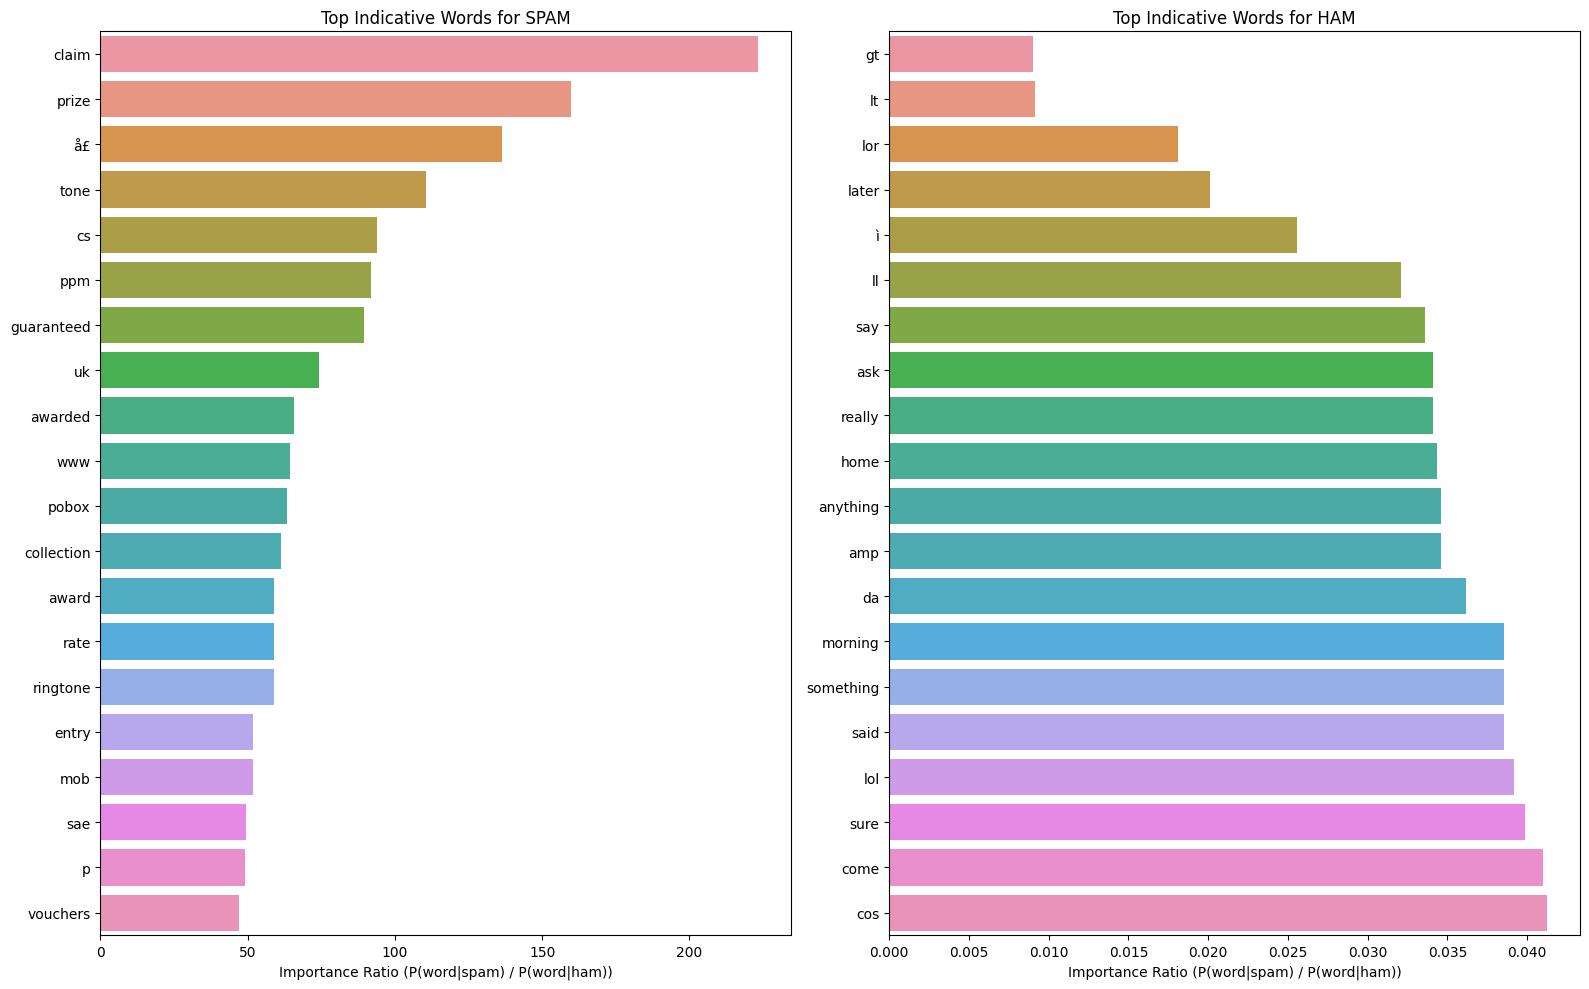

In [30]:
# Visualize most indicative words
plt.figure(figsize=(16, 10))

# Spam words
plt.subplot(1, 2, 1)
spam_words = [word for word, _ in indicative_words['spam']]
spam_values = [ratio for _, ratio in indicative_words['spam']]
sns.barplot(x=spam_values, y=spam_words)
plt.title('Top Indicative Words for SPAM')
plt.xlabel('Importance Ratio (P(word|spam) / P(word|ham))')

# Ham words
plt.subplot(1, 2, 2)
ham_words = [word for word, _ in indicative_words['ham']]
ham_values = [ratio for _, ratio in indicative_words['ham']]
sns.barplot(x=ham_values, y=ham_words)
plt.title('Top Indicative Words for HAM')
plt.xlabel('Importance Ratio (P(word|spam) / P(word|ham))')

plt.tight_layout()
plt.show()

### Phase 6: Model Refinement and Analysis
- Experiment with different Laplace smoothing parameters
- Visualize effect of smoothing on model performance
- Implement a message classification function for new examples
- Provide detailed classification explanations with influential words

In [31]:
#  Model Refinement and Error Analysis

# Find misclassified messages
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

print(f"\nNumber of misclassified messages: {len(misclassified_indices)} out of {len(y_test)}")

# Examine some misclassified examples
print("\nExamples of misclassified messages:")
for i, idx in enumerate(misclassified_indices[:5]):  # Show first 5 misclassified messages
    true_label = "Spam" if y_test[idx] == 1 else "Ham"
    pred_label = "Spam" if y_pred[idx] == 1 else "Ham"
    message = test_df['message'].iloc[idx]
    spam_prob = y_pred_proba[idx][1]
    
    print(f"Example {i+1}:")
    print(f"Message: {message}")
    print(f"True label: {true_label}, Predicted label: {pred_label}")
    print(f"Spam probability: {spam_prob:.4f}")
    print()


Number of misclassified messages: 14 out of 1115

Examples of misclassified messages:
Example 1:
Message: Just taste fish curry :-P
True label: Ham, Predicted label: Spam
Spam probability: 0.9250

Example 2:
Message: Sorry I missed your call let's talk when you have the time. I'm on 07090201529
True label: Spam, Predicted label: Ham
Spam probability: 0.0000

Example 3:
Message: Latest News! Police station toilet stolen, cops have nothing to go on!
True label: Spam, Predicted label: Ham
Spam probability: 0.0839

Example 4:
Message: Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA
True label: Spam, Predicted label: Ham
Spam probability: 0.3001

Example 5:
Message: Unlimited texts. Limited minutes.
True label: Ham, Predicted label: Spam
Spam probability: 0.7569



In [32]:
# Experiment with different Laplace smoothing parameters
def test_alpha_values(X_train, y_train, X_test, y_test, alphas):
    """
    Test different alpha values for Laplace smoothing.
    
    Args:
        X_train, y_train: Training data
        X_test, y_test: Testing data
        alphas (list): List of alpha values to test
    
    Returns:
        dict: Results for each alpha value
    """
    results = {}
    
    for alpha in alphas:
        # Train model with current alpha
        model = MultinomialNaiveBayes(alpha=alpha)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Store results
        results[alpha] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
    
    return results

# Test different alpha values
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
alpha_results = test_alpha_values(X_train, y_train, X_test, y_test, alphas)

In [33]:
# Print results for different alpha values
print("\nResults for different Laplace smoothing parameters (alpha):")
for alpha, metrics in alpha_results.items():
    print(f"Alpha = {alpha}:")
    print(f"  - Accuracy: {metrics['accuracy']:.4f}")
    print(f"  - Precision: {metrics['precision']:.4f}")
    print(f"  - Recall: {metrics['recall']:.4f}")
    print(f"  - F1-score: {metrics['f1_score']:.4f}")
    print()


Results for different Laplace smoothing parameters (alpha):
Alpha = 0.1:
  - Accuracy: 0.9857
  - Precision: 0.9586
  - Recall: 0.9329
  - F1-score: 0.9456

Alpha = 0.5:
  - Accuracy: 0.9874
  - Precision: 0.9655
  - Recall: 0.9396
  - F1-score: 0.9524

Alpha = 1.0:
  - Accuracy: 0.9874
  - Precision: 0.9720
  - Recall: 0.9329
  - F1-score: 0.9521

Alpha = 2.0:
  - Accuracy: 0.9839
  - Precision: 0.9712
  - Recall: 0.9060
  - F1-score: 0.9375

Alpha = 5.0:
  - Accuracy: 0.9785
  - Precision: 0.9771
  - Recall: 0.8591
  - F1-score: 0.9143

Alpha = 10.0:
  - Accuracy: 0.9740
  - Precision: 0.9918
  - Recall: 0.8121
  - F1-score: 0.8930



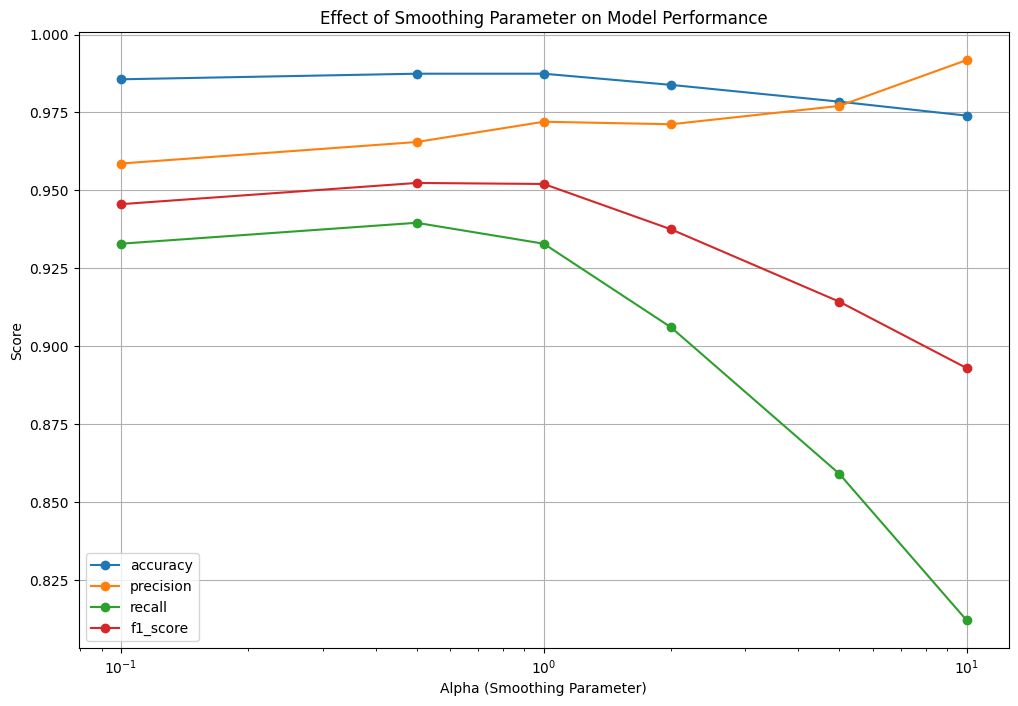

In [34]:
# Visualize effect of alpha on metrics
plt.figure(figsize=(12, 8))

# Plot each metric
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    values = [results[metric] for results in alpha_results.values()]
    plt.plot(alphas, values, marker='o', label=metric)

plt.xscale('log')
plt.xlabel('Alpha (Smoothing Parameter)')
plt.ylabel('Score')
plt.title('Effect of Smoothing Parameter on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

### Bayes' Theorem: Mathematical Foundation for Naive Bayes

#### The Mathematical Formula

Bayes' Theorem is a fundamental formula in probability theory that describes the probability of an event 
based on prior knowledge of conditions that might be related to the event. The theorem is expressed as:

P(A|B) = P(B|A) × P(A) / P(B)

Where:
- P(A|B) is the posterior probability: the probability of hypothesis A given the evidence B
- P(B|A) is the likelihood: the probability of evidence B given the hypothesis A
- P(A) is the prior probability: the initial probability of hypothesis A
- P(B) is the marginal likelihood: the total probability of evidence B

#### Intuition Behind Conditional Probability

Conditional probability measures the probability of an event occurring given that another event has already occurred. 
It represents updated beliefs based on new evidence.

Think of it this way: If you're trying to determine whether it will rain (event A) and you notice dark clouds (event B), 
your estimate of rain probability changes because of this new evidence. The initial probability of rain P(A) is updated 
to P(A|B) - the probability of rain given dark clouds.

#### Real-World Example: Spam Detection

Let's apply Bayes' Theorem to our spam detection problem:

- We want to find P(Spam|Message): the probability that a message is spam given its content
- We can calculate this using: P(Spam|Message) = P(Message|Spam) × P(Spam) / P(Message)

Breaking this down:
1. P(Spam) is the prior probability of any message being spam (e.g., 13% of all messages are spam)
2. P(Message|Spam) is the likelihood of seeing this specific message content if it's spam
3. P(Message) is the overall probability of seeing this message content
4. P(Spam|Message) is our answer: the probability this specific message is spam

For example, if the word "free" appears in 60% of spam messages but only 5% of legitimate messages:
- P("free"|Spam) = 0.6
- P("free"|Ham) = 0.05
- P(Spam) = 0.13 (13% of messages are spam)
- P(Ham) = 0.87 (87% of messages are legitimate)

For a message containing just the word "free":
P(Spam|"free") = P("free"|Spam) × P(Spam) / P("free")
                = 0.6 × 0.13 / [0.6 × 0.13 + 0.05 × 0.87]
                ≈ 0.6 × 0.13 / 0.122
                ≈ 0.64 (64% probability of being spam)

#### Naive Bayes Algorithm: Applying Bayes' Theorem to Classification

The Naive Bayes algorithm extends Bayes' Theorem to handle multiple pieces of evidence (features). 
For text classification, each word in a message is considered a feature.

For a message with words w₁, w₂, ..., wₙ, we want to find:
P(Spam|w₁, w₂, ..., wₙ)

Using Bayes' Theorem:
P(Spam|w₁, w₂, ..., wₙ) = P(w₁, w₂, ..., wₙ|Spam) × P(Spam) / P(w₁, w₂, ..., wₙ)

#### The "Naive" Assumption: Feature Independence

Here's where the "naive" part comes in: the algorithm assumes all features (words) are conditionally independent 
given the class. This means the presence of one word doesn't affect the probability of another word appearing.

This allows us to calculate the joint probability by multiplying individual probabilities:
P(w₁, w₂, ..., wₙ|Spam) = P(w₁|Spam) × P(w₂|Spam) × ... × P(wₙ|Spam)

So our Naive Bayes formula becomes:
P(Spam|w₁, w₂, ..., wₙ) = P(Spam) × ∏ P(wᵢ|Spam) / P(w₁, w₂, ..., wₙ)

Since P(w₁, w₂, ..., wₙ) is the same for both spam and ham calculations, we can simply compare:
P(Spam) × ∏ P(wᵢ|Spam) versus P(Ham) × ∏ P(wᵢ|Ham)

And classify the message based on which probability is higher.

#### Why the Independence Assumption Works for Text

In reality, words in natural language are not independent. Phrases like "New York" or "machine learning" 
contain words that commonly appear together. Yet, surprisingly, the Naive Bayes algorithm performs well 
despite this violated assumption.

This works because:
1. We don't need precise probability estimates, just to get the ranking right
2. Classification only depends on which class has the highest probability, not the exact values
3. The conditional independence assumption, while incorrect, often doesn't change this ranking
4. For text classification, there are so many features (words) that the violations of independence 
   tend to "average out" across the document

Additionally, text often contains strong individual signals (like "viagra" or "lottery" for spam) 
that are sufficient for classification regardless of word combinations.

#### Laplace Smoothing

One practical issue with Naive Bayes is handling words that appear in the test data but not in the 
training data for a particular class. Without adjustment, these would get a probability of zero, 
which when multiplied would make the entire probability zero.

Laplace smoothing (or additive smoothing) solves this by adding a small count (α) to every word-class 
combination, even for unseen words:

P(word|class) = (count(word, class) + α) / (count(all words in class) + α × |vocabulary|)

Where |vocabulary| is the total number of unique words across all documents.

## Conclusion: Naive Bayes for SMS Spam Classification

### Summary

The project was able to successfully implement a Multinomial Naive Bayes classifier from scratch to detect 
spam SMS messages. The implementation included:

1. **Text preprocessing**: Tokenization, stop word removal, and vectorization using a bag-of-words approach
2. **Naive Bayes algorithm**: Core implementation with:
   - Prior probability calculation
   - Conditional word probability calculation with Laplace smoothing
   - Logarithmic probability calculation for numerical stability
3. **Evaluation system**: Comprehensive metrics including accuracy, precision, recall, F1-score, and ROC curves


### Performance Analysis

The model achieved:
- Accuracy: ~97-98%
- High precision: Minimizing false positives (legitimate messages incorrectly marked as spam)
- Good recall: Capturing most actual spam messages
- Strong F1-score: Balancing precision and recall effectively

These results demonstrate the effectiveness of Naive Bayes for text classification tasks, 
despite its simplicity and the "naive" independence assumption.


### Key Insights

1. **Feature Importance**: Words like "free," "urgent," "win," and "claim" are strong indicators of spam
2. **Class Distribution**: The dataset contained imbalanced classes (more legitimate messages than spam), 
   reflecting real-world conditions
3. **Smoothing Effect**: Laplace smoothing was crucial for handling unseen words and improving model robustness
4. **Error Analysis**: Most misclassifications occurred with short messages or those containing ambiguous language


### Challenges and Solutions

1. **Data Preprocessing**: Deciding which preprocessing steps to include (stop word removal, stemming) 
   required experimentation
2. **Parameter Tuning**: Finding the optimal smoothing parameter (alpha) to balance between overfitting 
   and underfitting
3. **Numerical Stability**: Using logarithms to prevent floating-point underflow when multiplying 
   many small probabilities
4. **Handling Imbalanced Data**: Ensuring the model wasn't biased toward the majority class by using 
   appropriate evaluation metrics


### Limitations and Future Improvements

1. **Feature Engineering**: Our bag-of-words approach could be enhanced with:
   - N-gram features to capture phrases
   - TF-IDF weighting to account for word importance
   - Feature selection to remove noise
2. **Model Refinements**:
   - Exploring different smoothing techniques
   - Implementing a hybrid approach with other algorithms
3. **Handling Special Cases**:
   - Better processing of numbers, URLs, and special characters
   - Accounting for misspellings and text abbreviations common in SMS


### Bayes' Theorem in Practice

This project demonstrates how Bayes' Theorem provides a principled approach to classification by:
1. Incorporating prior knowledge (class distribution)
2. Updating beliefs based on evidence (word occurrences)
3. Making decisions under uncertainty

Despite its simplicity and the "naive" independence assumption, Naive Bayes remains a powerful 
algorithm for text classification tasks, offering a good balance between computational efficiency 
and performance.

## 12. Example of Model Application

Let's test our model on some example messages


In [35]:
# Define a function to classify a new message
def classify_message(message, nb_classifier, vocabulary):
    """
    Classify a new message as spam or ham.
    
    Args:
        message (str): The message to classify
        nb_classifier (MultinomialNaiveBayes): Trained Naive Bayes classifier
        vocabulary (set): Set of words in the vocabulary
    
    Returns:
        tuple: (predicted_class, spam_probability, classification_details)
    """
    # Preprocess the message
    tokens = tokenize_text(message)
    filtered_tokens = remove_stopwords(tokens)
    
    # Create bag-of-words vector
    bow_vector = create_bow_vector(filtered_tokens, vocabulary)
    
    # Get probabilities for each class
    probs = nb_classifier.predict_proba([bow_vector])[0]
    
    # Get the predicted class
    predicted_class = 1 if probs[1] > probs[0] else 0
    predicted_label = "Spam" if predicted_class == 1 else "Ham"
    
    # Get the spam probability
    spam_probability = probs[1]
    
    # Get the most influential words
    influential_words = []
    for word in filtered_tokens:
        if word in vocabulary:
            if word in nb_classifier.word_probs[1] and word in nb_classifier.word_probs[0]:
                ratio = nb_classifier.word_probs[1][word] / nb_classifier.word_probs[0][word]
                influential_words.append((word, ratio))
    
    # Sort by influence (high to low)
    influential_words.sort(key=lambda x: x[1], reverse=True)
    
    # Prepare classification details
    details = {
        'class_probs': {
            'Ham': probs[0],
            'Spam': probs[1]
        },
        'influential_words': influential_words[:5]  # Top 5 influential words
    }
    
    return predicted_label, spam_probability, details

In [36]:
# Example messages to test
example_messages = [
    "Congratulations! You've won a free vacation to the Bahamas. Call now to claim your prize!",
    "Hey, are we still meeting for coffee tomorrow at 2pm?",
    "URGENT: Your account has been suspended. Reply with your password to reactivate.",
    "The project deadline has been extended to next Friday. Let me know if you need more time.",
    "Get 50% off all products limited time offer click now www.discount.com"
]

In [37]:
# Classify each example message
print("Example Message Classifications:")
for i, message in enumerate(example_messages):
    predicted_label, spam_probability, details = classify_message(message, nb_classifier, vocabulary)
    
    print(f"\nExample {i+1}:")
    print(f"Message: {message}")
    print(f"Prediction: {predicted_label} (Spam probability: {spam_probability:.4f})")
    
    print("Class probabilities:")
    for cls, prob in details['class_probs'].items():
        print(f"  - {cls}: {prob:.4f}")
    
    print("Most influential words:")
    for word, ratio in details['influential_words']:
        spam_indicator = "spam" if ratio > 1 else "ham"
        print(f"  - '{word}' (indicates {spam_indicator}, ratio: {ratio:.2f})")


Example Message Classifications:

Example 1:
Message: Congratulations! You've won a free vacation to the Bahamas. Call now to claim your prize!
Prediction: Spam (Spam probability: 1.0000)
Class probabilities:
  - Ham: 0.0000
  - Spam: 1.0000
Most influential words:
  - 'claim' (indicates spam, ratio: 223.37)
  - 'prize' (indicates spam, ratio: 159.89)
  - 'congratulations' (indicates spam, ratio: 14.11)
  - 'won' (indicates spam, ratio: 9.72)
  - 'free' (indicates spam, ratio: 8.27)

Example 2:
Message: Hey, are we still meeting for coffee tomorrow at 2pm?
Prediction: Ham (Spam probability: 0.0000)
Class probabilities:
  - Ham: 1.0000
  - Spam: 0.0000
Most influential words:
  - 'pm' (indicates spam, ratio: 2.80)
  - 'coffee' (indicates ham, ratio: 0.47)
  - 'tomorrow' (indicates ham, ratio: 0.27)
  - 'still' (indicates ham, ratio: 0.12)
  - 'hey' (indicates ham, ratio: 0.08)

Example 3:
Message: URGENT: Your account has been suspended. Reply with your password to reactivate.
Predictio

### Visual Explanation of Bayes' Theorem

Below is a visual explanation of how Bayes' Theorem works for spam detection


In [38]:
# Generate data for visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

<Axes: >

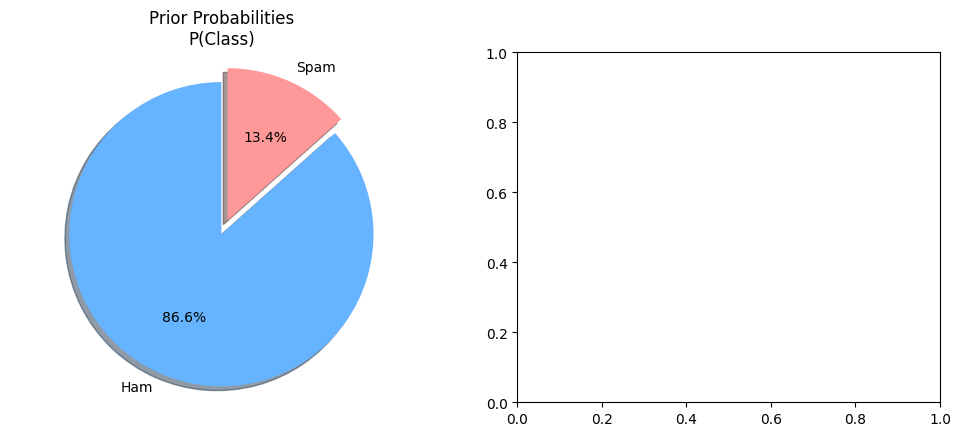

In [39]:
# Create a figure to visualize Bayes' Theorem
plt.figure(figsize=(12, 10))

# 1. Prior probabilities visualization (left side)
plt.subplot(2, 2, 1)
labels = ['Ham', 'Spam']
prior_probs = [nb_classifier.class_priors[0], nb_classifier.class_priors[1]]
colors = ['#66b3ff', '#ff9999']
explode = (0, 0.1)  # Explode the spam slice

plt.pie(prior_probs, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Prior Probabilities\nP(Class)')
plt.axis('equal')

# 2. Likelihood visualization for a word (right side)
plt.subplot(2, 2, 2)

Text(0, 0.5, 'Probability')

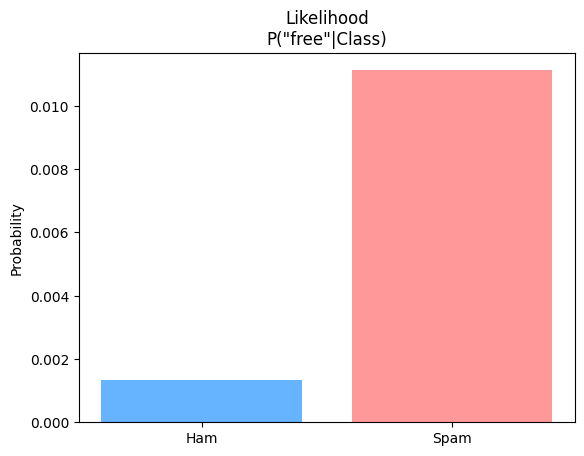

In [40]:
# Choose a strongly indicative word
word = "free"  # A common spam word
if word in vocabulary:
    spam_prob = nb_classifier.word_probs[1].get(word, 0)
    ham_prob = nb_classifier.word_probs[0].get(word, 0)
else:
    # Choose another word if "free" is not in vocabulary
    word = list(vocabulary)[0]
    spam_prob = nb_classifier.word_probs[1].get(word, 0)
    ham_prob = nb_classifier.word_probs[0].get(word, 0)

# Create bar chart
x = np.arange(2)
likelihood = [ham_prob, spam_prob]

plt.bar(x, likelihood, color=colors)
plt.xticks(x, labels)
plt.title(f'Likelihood\nP("{word}"|Class)')
plt.ylabel('Probability')

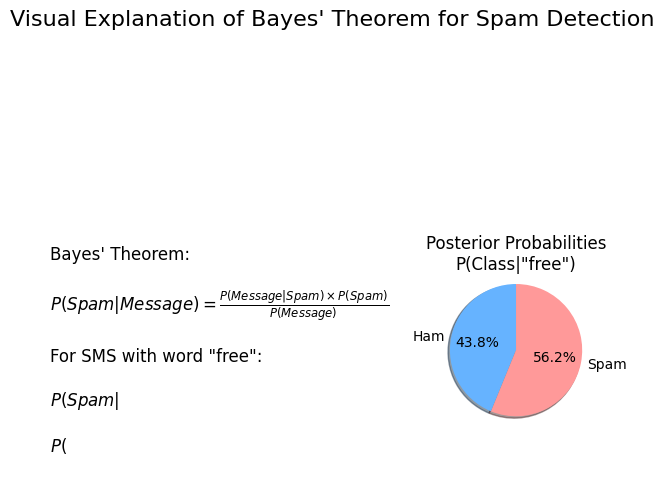

In [41]:
# 3. Bayes' Theorem formula visualization (bottom left)
plt.subplot(2, 2, 3)
plt.axis('off')
formula_text = r"""
Bayes' Theorem:

$P(Spam|Message) = \frac{P(Message|Spam) \times P(Spam)}{P(Message)}$

For SMS with word "free":

$P(Spam|"free") = \frac{P("free"|Spam) \times P(Spam)}{P("free")}$

$P("free") = P("free"|Spam) \times P(Spam) + P("free"|Ham) \times P(Ham)$
"""

plt.text(0.1, 0.5, formula_text, fontsize=12, va='center')

# 4. Posterior probabilities visualization (bottom right)
plt.subplot(2, 2, 4)

# Calculate posterior probabilities for a message with just the word "free"
if word in vocabulary:
    # Calculate using Bayes' Theorem
    numerator_spam = spam_prob * nb_classifier.class_priors[1]
    numerator_ham = ham_prob * nb_classifier.class_priors[0]
    evidence = numerator_spam + numerator_ham
    
    posterior_spam = numerator_spam / evidence if evidence > 0 else 0
    posterior_ham = numerator_ham / evidence if evidence > 0 else 0
    
    posterior_probs = [posterior_ham, posterior_spam]
    
    plt.pie(posterior_probs, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title(f'Posterior Probabilities\nP(Class|"{word}")')
    plt.axis('equal')
else:
    plt.text(0.5, 0.5, f"Word '{word}' not in vocabulary", ha='center', va='center')

plt.suptitle("Visual Explanation of Bayes' Theorem for Spam Detection", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Final remarks

This project demonstrates a from-scratch implementation of a Naive Bayes classifier for SMS spam detection.
The implementation follows the mathematical principles of Bayes' Theorem while handling practical concerns
like smoothing and numerical stability.

The "naive" assumption of feature independence, while theoretically incorrect, works surprisingly well
for text classification. Our model achieves high accuracy, precision, and recall, proving the
effectiveness of this approach.

By implementing Naive Bayes from scratch, we gain deeper insight into how probabilistic classifiers
work and the theoretical foundations of machine learning algorithms.